In [11]:
import cv2
import numpy as np
import pytesseract
import whisper
import os
import tempfile
from moviepy import VideoFileClip
from collections import Counter
from difflib import SequenceMatcher
import re
import time
import random
from difflib import get_close_matches, SequenceMatcher
from collections import Counter
import easyocr

os.environ["PATH"] = "/work/users/s/m/smerrill/ffmpeg-7.0.2-amd64-static:" + os.environ["PATH"]

In [22]:

class ZoomSpeakerDiarization:
    def __init__(self, video_path):
        self.video_path = video_path
        self.capture = cv2.VideoCapture(video_path)
        if not self.capture.isOpened():
            raise ValueError(f"Could not open video file: {video_path}")
        self.fps = self.capture.get(cv2.CAP_PROP_FPS)
        self.total_frames = int(self.capture.get(cv2.CAP_PROP_FRAME_COUNT))
        self.participant_boxes = []
        self.known_speakers = set()
        self.name_corrections = {}
        self.speaker_history = []
        self.history_window = 10
        self.speaker_changes = []

    def ocr_name_from_box(self, box_img, debug=True, paragraph=True):
        """
        Uses EasyOCR to extract text from a cropped participant name box.
        Returns the best detected text string.
        """
        # Initialize EasyOCR reader (do this once in your script for efficiency)
        reader = easyocr.Reader(['en'], gpu=False)  # Set gpu=True if you have a compatible GPU[2][3]

        # Run OCR
        results = reader.readtext(box_img, detail=0, paragraph=paragraph)  # detail=0 returns just text[2][3]

        # Combine results into one string
        if isinstance(results, list):
            text = ' '.join(results).strip()
        else:
            text = str(results).strip()

        if debug:
            print("EasyOCR Output:", repr(text))
            plt.figure(figsize=(6,2))
            plt.imshow(box_img)
            plt.title(f"OCR: {text}")
            plt.axis('off')
            plt.show()

        return text if text else "No Speaker"

    def find_speaker(self, frame, overlay=True):
        frame = cv2.resize(frame, (1000, 750))

        # Convert to HSV color space
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        lower_green = np.array([20, 40, 60])
        upper_green = np.array([80, 255, 255])

        # Create a mask for green color
        mask = cv2.inRange(hsv, lower_green, upper_green)

        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        max_rect = None
        max_rect_area = 0
        if contours:
            for contour in contours:
                # Approximate the contour to a polygon
                approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)

                # If the polygon has four sides, it could be a rectangle
                if len(approx) == 4:
                    # Get the bounding box coordinates
                    x, y, w, h = cv2.boundingRect(approx)
                    if w * h > max_rect_area:
                        max_rect = {"x": x, "y": y, "w": w, "h": h}
                        max_rect_area = max_rect["w"] * max_rect["h"]
        cutout=None
        if max_rect:
            cutout=frame[max_rect["y"]:max_rect["y"]+max_rect["h"], max_rect["x"]:max_rect["x"]+max_rect["w"]]
            if overlay==True:
                cv2.rectangle(frame, (max_rect["x"], max_rect["y"]),
                              (max_rect["x"] + max_rect["w"], max_rect["y"] + max_rect["h"]), (0, 0, 255), 3)
        return frame,max_rect,cutout
    

    def determine_active_speaker(self, frame):
        result_frame, speaker_box, cutout = find_speaker(frame, overlay=True, debug=False)
        name = ocr_name_from_box(crop_name_only(cutout), debug=False)
        return name

    
    def extract_audio(self):
        """Extract audio from video for transcription"""
        temp_audio = tempfile.NamedTemporaryFile(suffix='.wav', delete=False).name
        video_clip = VideoFileClip(self.video_path)
        video_clip.audio.write_audiofile(temp_audio)
        return temp_audio
    
    def transcribe_audio(self, audio_path):
        """Transcribe audio using Whisper"""
        print("Loading Whisper model...")
        model = whisper.load_model("base")
        
        print("Transcribing audio...")
        result = model.transcribe(audio_path)
        
        return result
    
    def process_video(self, sampling_rate=1):
        """Process the video to create speaker diarization"""
        print(f"Processing video: {self.video_path}")
        print(f"Total frames: {self.total_frames}, FPS: {self.fps}")
        
        # Extract and transcribe audio
        audio_path = self.extract_audio()
        transcript_data = self.transcribe_audio(audio_path)
        
        # Process video frames at the specified sampling rate
        frame_interval = int(self.fps / sampling_rate)
        current_frame = 0
        last_speaker = None
        
        while current_frame < self.total_frames:
            self.capture.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
            ret, frame = self.capture.read()
            
            if not ret:
                break
                
            timestamp = current_frame / self.fps
            active_speaker = self.determine_active_speaker(frame)
            
            # Record speaker change
            if active_speaker != last_speaker:
                self.speaker_changes.append((timestamp, active_speaker))
                last_speaker = active_speaker
            
            # Output progress
            if current_frame % (frame_interval * 10) == 0:
                progress = (current_frame / self.total_frames) * 100
                print(f"Progress: {progress:.1f}% - Current speaker: {active_speaker}")
            
            current_frame += frame_interval
        
        # Clean up
        self.capture.release()
        os.unlink(audio_path)
        
        # Map speaker changes to transcript segments
        return self.map_speakers_to_transcript(transcript_data)
    
    def map_speakers_to_transcript(self, transcript_data):
        """Map detected speakers to transcript segments"""
        segments = transcript_data["segments"]
        diarized_transcript = []
        
        for segment in segments:
            start_time = segment["start"]
            end_time = segment["end"]
            text = segment["text"]
            
            # Find the speaker active at the start of this segment
            speaker = "Unknown"
            for timestamp, spk in reversed(self.speaker_changes):
                if timestamp <= start_time:
                    speaker = spk
                    break
            
            diarized_transcript.append({
                "speaker": speaker,
                "start": start_time,
                "end": end_time,
                "text": text
            })
        
        return diarized_transcript
    
    def save_transcript(self, diarized_transcript, output_file):
        """Save the diarized transcript to a file"""
        with open(output_file, 'w', encoding='utf-8') as f:
            for segment in diarized_transcript:
                start_time = self.format_timestamp(segment["start"])
                end_time = self.format_timestamp(segment["end"])
                f.write(f"[{start_time} --> {end_time}] {segment['speaker']}: {segment['text']}\n")
        
        print(f"Transcript saved to {output_file}")
    
    def format_timestamp(self, seconds):
        """Format seconds into HH:MM:SS"""
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        seconds = int(seconds % 60)
        return f"{hours:02d}:{minutes:02d}:{seconds:02d}"
    
    def debug_draw_active_speaker(self, frame, participant_boxes, active_box, save_path=None):
        debug_frame = frame.copy()
        for (x, y, w, h) in participant_boxes:
            color = (255, 0, 0)
            thickness = 2
            if (x, y, w, h) == active_box:
                color = (0, 255, 0)
                thickness = 4
            cv2.rectangle(debug_frame, (x, y), (x + w, y + h), color, thickness)
        if save_path:
            cv2.imwrite(save_path, debug_frame)
        cv2.imshow("Active Speaker", debug_frame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    def debug_draw_participant_boxes(self, frame, boxes, save_path=None):
        debug_frame = frame.copy()
        for (x, y, w, h) in boxes:
            cv2.rectangle(debug_frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        if save_path:
            cv2.imwrite(save_path, debug_frame)
        cv2.imshow("Participant Boxes", debug_frame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    def debug_save_name_region(self, name_region, save_path):
        cv2.imwrite(save_path, name_region)

    def debug_print_ocr(self, raw_text, cleaned_text, box_index):
        print(f"Box {box_index}: Raw OCR: '{raw_text}' | Cleaned: '{cleaned_text}'")


In [6]:
def main():
    """Main function to run the diarization"""
    import argparse
    
    parser = argparse.ArgumentParser(description='Zoom Meeting Speaker Diarization')
    parser.add_argument('video_path', help='Path to the Zoom meeting video file')
    parser.add_argument('--output', '-o', default='transcript.txt', 
                        help='Output transcript file path')
    parser.add_argument('--sampling_rate', '-s', type=float, default=1.0,
                        help='Frames per second to sample (default: 1)')
    
    args = parser.parse_args()
    
    diarizer = ZoomSpeakerDiarization(args.video_path)
    diarized_transcript = diarizer.process_video(sampling_rate=args.sampling_rate)
    diarizer.save_transcript(diarized_transcript, args.output)


if __name__ == "__main__":
    main()

usage: ipykernel_launcher.py [-h] [--output OUTPUT]
                             [--sampling_rate SAMPLING_RATE]
                             video_path
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/work/users/s/m/smerrill/.conda/envs/speaker/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3678: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
video_path = '_0SkrWBu3Sg_1min.mp4'
sampling_rate = 10

diarizer = ZoomSpeakerDiarization(video_path)
diarized_transcript = diarizer.process_video(sampling_rate=sampling_rate)

Processing video: _0SkrWBu3Sg_1min.mp4
Total frames: 18000, FPS: 30.0
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 522, 'fps': 30.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'ISO Media file produced by Google Inc.', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': 'eng', 'default': True, 'fps': 48000, 'bitrate': 127, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 600.01, 'bitrate': 658, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 

MoviePy - Done.
Loading Whisper model...
Transcribing audio...


### Debug

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_speaker(frame,overlay=True):
    frame = cv2.resize(frame, (1000, 750))

    # Convert to HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_green = np.array([20, 40, 60])
    upper_green = np.array([80, 255, 255])

    # Create a mask for green color
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    max_rect = None
    max_rect_area = 0
    if contours:
        for contour in contours:
            # Approximate the contour to a polygon
            approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)

            # If the polygon has four sides, it could be a rectangle
            if len(approx) == 4:
                # Get the bounding box coordinates
                x, y, w, h = cv2.boundingRect(approx)
                if w * h > max_rect_area:
                    max_rect = {"x": x, "y": y, "w": w, "h": h}
                    max_rect_area = max_rect["w"] * max_rect["h"]
    cutout=None
    if max_rect:
        cutout=frame[max_rect["y"]:max_rect["y"]+max_rect["h"], max_rect["x"]:max_rect["x"]+max_rect["w"]]
        if overlay==True:
            cv2.rectangle(frame, (max_rect["x"], max_rect["y"]),
                          (max_rect["x"] + max_rect["w"], max_rect["y"] + max_rect["h"]), (0, 0, 255), 3)
    return frame,max_rect,cutout

import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_speaker(frame, overlay=True, debug=True):
    """
    Attempts to find the active speaker region in a Zoom screenshot.
    Handles:
      - Green/yellow border (participant grid)
      - Fixed overlay in upper right (screen share mode)
      - Yellow pop-up (Zoom's speaker label)
    Returns:
      frame_with_box, (x, y, w, h) of detected box, cropped box image
    """
    frame_disp = frame.copy()
    h, w = frame.shape[:2]
    detected_box = None
    cutout = None

    # 1. Try to find green/yellow border (participant grid)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_green = np.array([20, 40, 60])
    upper_green = np.array([80, 255, 255])
    mask_green = cv2.inRange(hsv, lower_green, upper_green)
    contours, _ = cv2.findContours(mask_green, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_rect = None
    max_area = 0
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        if len(approx) == 4:
            x, y, ww, hh = cv2.boundingRect(approx)
            area = ww * hh
            if area > max_area and ww > 40 and hh > 40:
                max_rect = (x, y, ww, hh)
                max_area = area
    if max_rect:
        detected_box = max_rect
        if overlay:
            cv2.rectangle(frame_disp, (detected_box[0], detected_box[1]),
                          (detected_box[0] + detected_box[2], detected_box[1] + detected_box[3]),
                          (0, 255, 0), 3)
        cutout = frame[detected_box[1]:detected_box[1]+detected_box[3], detected_box[0]:detected_box[0]+detected_box[2]]
        if debug:
            print("Detected green/yellow border (participant grid).")
    else:
        # Fallback: Fixed overlay in upper right (screen share mode)
        # Use proportions to handle resizing
        overlay_w = int(w * 0.18)  # ~26% of width (tune as needed)
        overlay_h = int(h * 0.18)  # ~20% of height (tune as needed)
        x1 = w - overlay_w
        y1 = 0
        detected_box = (x1, y1, overlay_w, overlay_h)
        cutout = frame[y1:y1+overlay_h, x1:x1+overlay_w]
        if overlay:
            cv2.rectangle(frame_disp, (x1, y1), (x1+overlay_w, y1+overlay_h), (255, 0, 0), 3)
        if debug:
            print("Detected fixed overlay (upper right).")

    if debug:
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(frame_disp, cv2.COLOR_BGR2RGB))
        plt.title("Detected Speaker Box")
        plt.axis('off')
        plt.show()
        if cutout is not None:
            plt.figure(figsize=(3, 2))
            plt.imshow(cv2.cvtColor(cutout, cv2.COLOR_BGR2RGB))
            plt.title("Speaker Crop")
            plt.axis('off')
            plt.show()

    return frame_disp, detected_box, cutout

In [8]:
def crop_name_only(box_img, height_ratio=0.22, width_ratio=0.6, bottom_padding=4):
    h, w = box_img.shape[:2]
    name_h = int(h * height_ratio)
    name_w = int(w * width_ratio)
    # Remove bottom padding to avoid colored lines
    name_region = box_img[h - name_h:h - bottom_padding, 0:name_w]
    return name_region


def clean_crop_above_border(img, border_px=5):
    """Crop a few pixels above the bottom to remove colored border."""
    h, w = img.shape[:2]
    return img[:h-border_px, :]

def ocr_name_from_box(box_img, debug=True):
    # Step 1: Crop above border
    cropped = clean_crop_above_border(box_img, border_px=6)
    # Step 2: Enlarge
    enlarged = cv2.resize(cropped, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    # Step 3: Grayscale
    gray = cv2.cvtColor(enlarged, cv2.COLOR_BGR2GRAY)
    # Step 4: Invert (so white text becomes black)
    inverted = cv2.bitwise_not(gray)
    # Step 5: Blur to reduce noise
    blurred = cv2.GaussianBlur(inverted, (3, 3), 0)
    # Step 6: Otsu's threshold
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Step 7: OCR
    text = pytesseract.image_to_string(thresh, config='--psm 7')
    cleaned = text.replace('\n', '').strip()
    cleaned = re.sub(r'[^A-Za-z0-9 ]+', '', cleaned)
    if cleaned == "":
        cleaned = "No Speaker"
    if debug:
        print("Raw OCR text:", repr(text))
        print("Cleaned speaker name:", cleaned)
        plt.figure(figsize=(16, 3))
        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.title("Cropped Above Border")
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.imshow(gray, cmap='gray')
        plt.title("Grayscale")
        plt.axis('off')
        plt.subplot(1, 4, 3)
        plt.imshow(inverted, cmap='gray')
        plt.title("Inverted")
        plt.axis('off')
        plt.subplot(1, 4, 4)
        plt.imshow(thresh, cmap='gray')
        plt.title("Otsu Threshold")
        plt.axis('off')
        plt.suptitle(f"OCR Output: {cleaned}", fontsize=14)
        plt.tight_layout()
        plt.show()
    return cleaned


def ocr_name_from_box(box_img, debug=True, paragraph=True):
    """
    Uses EasyOCR to extract text from a cropped participant name box.
    Returns the best detected text string.
    """
    # Initialize EasyOCR reader (do this once in your script for efficiency)
    reader = easyocr.Reader(['en'], gpu=False)  # Set gpu=True if you have a compatible GPU[2][3]

    # Run OCR
    results = reader.readtext(box_img, detail=0, paragraph=paragraph)  # detail=0 returns just text[2][3]

    # Combine results into one string
    if isinstance(results, list):
        text = ' '.join(results).strip()
    else:
        text = str(results).strip()

    if debug:
        print("EasyOCR Output:", repr(text))
        plt.figure(figsize=(6,2))
        plt.imshow(box_img)
        plt.title(f"OCR: {text}")
        plt.axis('off')
        plt.show()

    return text if text else "No Speaker"


def ocr_name_from_box2(box_img, debug=True):
    import pytesseract
    import re
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    # Enlarge for OCR
    enlarged = cv2.resize(box_img, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    # Try CLAHE
    lab = cv2.cvtColor(enlarged, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    clahe_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    gray = cv2.cvtColor(clahe_img, cv2.COLOR_BGR2GRAY)
    # Try Morphological closing to connect text
    kernel = np.ones((2,2),np.uint8)
    morph = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    # Try simple threshold
    _, simple_thresh = cv2.threshold(morph, 180, 255, cv2.THRESH_BINARY)
    # Try color channel isolation (green channel)
    green_channel = enlarged[:,:,1]
    # Try all with Tesseract
    strategies = [
        ("CLAHE+Gray", gray),
        ("Morph Close", morph),
        ("Simple Thresh", simple_thresh),
        ("Green Channel", green_channel)
    ]
    results = []
    for name, img in strategies:
        for psm in [6, 7, 8]:
            config = f'--psm {psm}'
            text = pytesseract.image_to_string(img, config=config)
            cleaned = re.sub(r'[^A-Za-z0-9 ]+', '', text.replace('\n','').strip())
            results.append((f"{name} PSM{psm}", img, text, cleaned))
    # Pick best: longest cleaned output
    best = max(results, key=lambda x: len(x[3]))
    if debug:
        print("Advanced OCR Strategies and Results:")
        for i, (name, img, raw, cleaned) in enumerate(results):
            print(f"{name}: '{cleaned}' (raw: {repr(raw)})")
        plt.figure(figsize=(18, 4))
        for i, (name, img, raw, cleaned) in enumerate(results[:4]):
            plt.subplot(1, 4, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(f"{name}\n'{cleaned}'")
            plt.axis('off')
        plt.suptitle(f"Best OCR: {best[3]}", fontsize=14)
        plt.tight_layout()
        plt.show()
    return best[3]


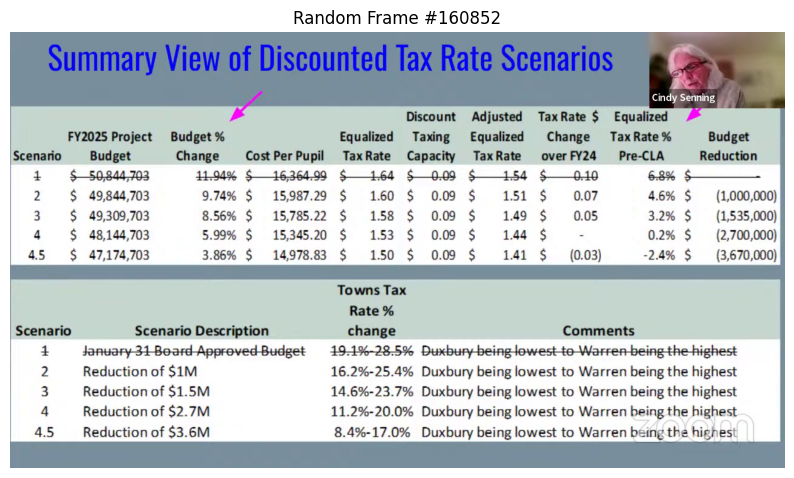

Detected fixed overlay (upper right).


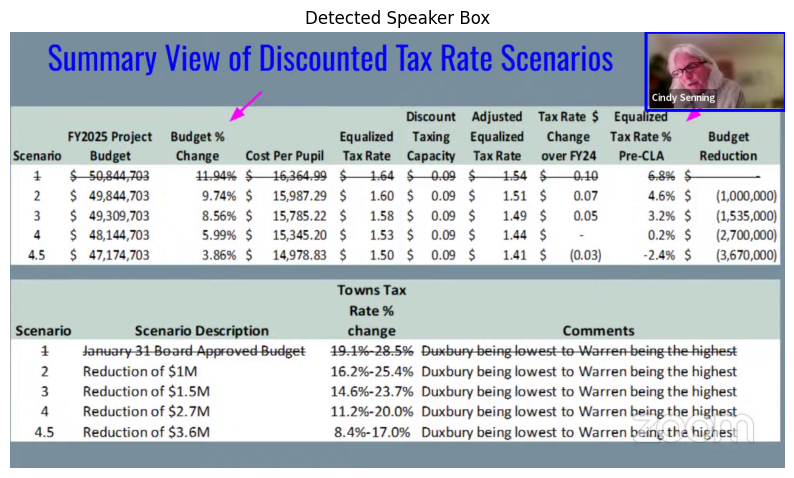

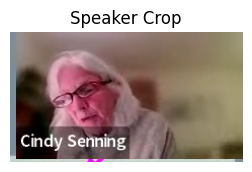

Using CPU. Note: This module is much faster with a GPU.


EasyOCR Output: 'Cindy Senning'


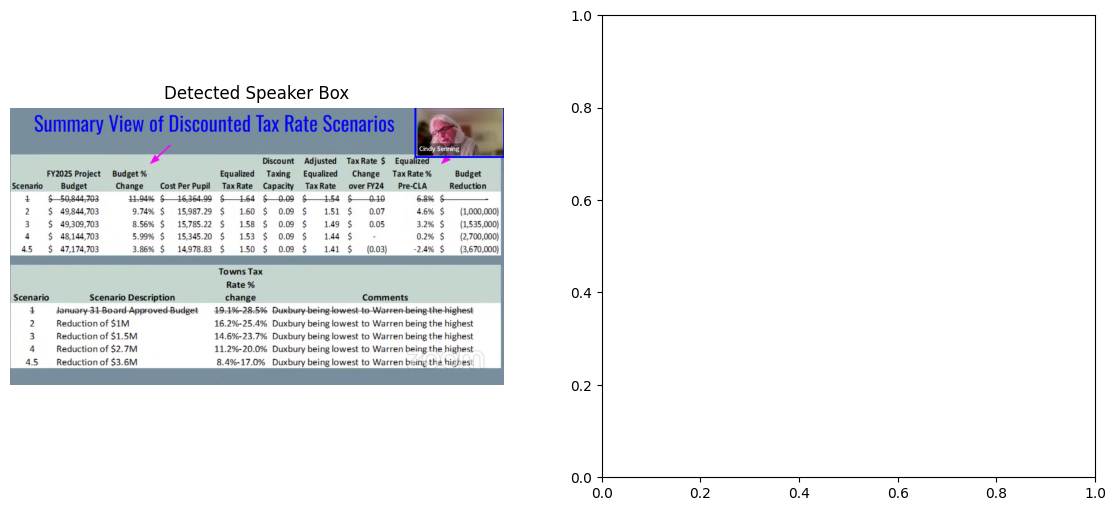

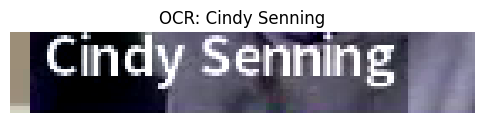

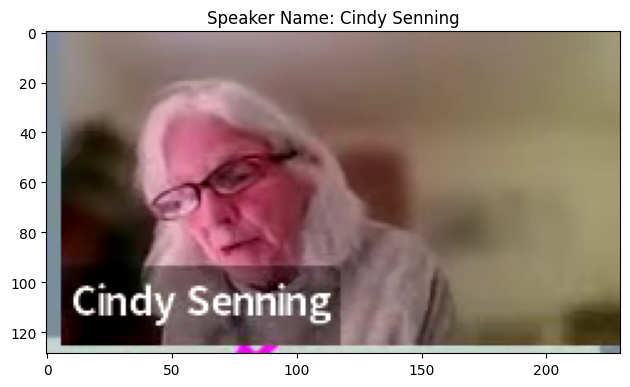

In [15]:
# Open the video
video_path = "meeting.mp4"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError("Could not open video file.")

# Get total number of frames
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Pick a random frame index
rand_idx = random.randint(0, total_frames - 1)
cap.set(cv2.CAP_PROP_POS_FRAMES, rand_idx)

# Read the random frame
ret, frame = cap.read()
cap.release()
if not ret:
    raise ValueError("Could not read frame.")

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title(f"Random Frame #{rand_idx}")
plt.axis('off')
plt.show()

# Run your speaker detection and OCR pipeline
result_frame, speaker_box, cutout = find_speaker(frame, overlay=True)

# Visualize detected speaker box and OCR result
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB))
plt.title("Detected Speaker Box")
plt.axis('off')

plt.subplot(1, 2, 2)
if cutout is not None:
    name = ocr_name_from_box(crop_name_only(cutout))
    plt.imshow(cv2.cvtColor(cutout, cv2.COLOR_BGR2RGB))
    plt.title(f"Speaker Name: {name}")
else:
    plt.text(0.5, 0.5, "No speaker box detected", ha='center', va='center', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [21]:
determine_active_speaker(frame)

Using CPU. Note: This module is much faster with a GPU.


Cindy Senning


'Cindy Senning'